In [1]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scope import ScopeSolver

Piecewise-linear trend filtering with periodic components
---------------------------------------------------------
### Introduction
As an extension of the 1D trend filtering, in this example, we suppose that the underlying true trend is piecewise linear (rather than piece-wise constant) and some periodic components exist.

For example, we want to identify the upside or downside trend of the financial market with the seasonal effect.


### Implementation

Given the time series $\mathbf{y}\in\mathbb{R}^T$, we want to recover the underlying piecewisly linear trend $\mathbf{x}$ and the periodic component $s_t=a\sin(wt)+b\cos(wt)$. 

Here, we assume that $w$ is known but the coefficients $a$ and $b$ are unknown. Similarly to the 1D trend filtering, we consider a reparametrization strategy which directly set the second order jump $\mathbf{\theta}$ as the sparse parameter.

Specifically, we can solve the following sparsity constrained optimization with ``scope``
$$
\min_{\mathbf{\theta}\in\mathbb{R}^T, a, b} \quad\frac{1}{2}\|\mathbf{y}-\mathbf{s}-\mathbf{A \theta}\|_2^2 \text{ s.t. } \|\mathbf{\theta}\|_0\leq s.
$$
where $s_t=a\sin(wt)+b\cos(wt)$ and $\mathbf{A}$ is the lower triangular matrix
$$
\mathbf{A}=\left[\begin{array}{cccccc}
1 & & & & & \\
1 & 1 & & & & \\
1 & 2 & 1 & & & \\
1 & 3 & 2 & \ddots & & \\
\vdots & \vdots & \vdots & \ddots & 1 & \\
1 & T-1 & T-2 & \cdots & 2 & 1
\end{array}\right] \in \mathbf{R}^{T \times T} .
$$
Then, we output $\mathbf{A\theta}$ as the underlying linear trend and $\mathbf{s}$ as the periodic component of $\mathbf{y}$.

In this example, we set $T=1000$ and firstly construct the transformed matrix $\mathbf{A}$ as follows.

In [2]:
T = 1000
A = np.zeros((T, T))
for i in range(T):
    if i == 0:
        A[:, i] = np.ones(T)
    else:
        A[:i, i] = np.zeros(i)
        A[i:, i] = np.arange(1, T-i+1)

The main function ``ptf`` cna be considered as a sparse linear regression with the design matrix being the concatenation of the base periodic components $\sin, \cos$ and $\mathbf{A}$ (see the function ``jnp.hstack`` below). 

In [3]:
def ptf(y, sparsity):
    T = len(y)
    def custom_objective(params):
        X_tmp = jnp.hstack([periods, A])
        loss = jnp.mean((y - X_tmp @ params) ** 2)
        return loss
    
    always_select = np.array([0, 1])
    solver = ScopeSolver(T+2, sparsity=sparsity, always_select=always_select)
    params = solver.solve(custom_objective)
    return params

### Synthetic data example

The synthetic time series data $\mathbf{y}\in\mathbb{R}^T$ where $T=1000$ is generated as follows:

- First, generate trend slopes $v_t$ from a Markov process such that $v_1=1$ and $v_{t+1}=v_t$ with probability 0.99 and from $U[-0.5, 0.5]$ with probability 0.01.  

- Then, generate true trend $x_t$ as $x_{t+1}=x_t+v_t, t=1,\cdots, T-1$ with $x_1=1$.  

- The periodic components are constructed as $s_t=a\times\sin(wt)+b\times\cos(wt)$ with $a=10, b=20, w=\pi/64$.

- Finally, the time series is generated by adding noise to the trend such that $y_t=x_t+s_t+z_t$ where $z_t$ are i.i.d. $\mathcal{N}(0, 10^2)$ noise.

In [4]:
np.random.seed(123)
sigma = 10
z = np.random.randn(T) * sigma
b = 0.5
v = np.ones(T)
prob = 0.99
rands = np.random.rand(T)
for i in range(1, T):
    rand = rands[i]
    if rand <= prob:
        v[i] = v[i-1]
    elif rand <= prob + (1-prob) / 2:
        v[i] = np.random.uniform(0, b)
    else:
        v[i] = - np.random.uniform(0, b)
x = np.ones(T)
for i in range(1, T):
    x[i] = x[i-1] + v[i-1]

w = np.pi / 64
periods = np.cumsum(np.ones((len(x), 2)), axis=0)
periods[:, 0] = np.sin(w * periods[:, 0])
periods[:, 1] = np.cos(w * periods[:, 1])
beta_period = np.array([10, 20])
s = periods @ beta_period
y = x + s + z

The original timeseries ant its true underlying trend is shown in the following figure.

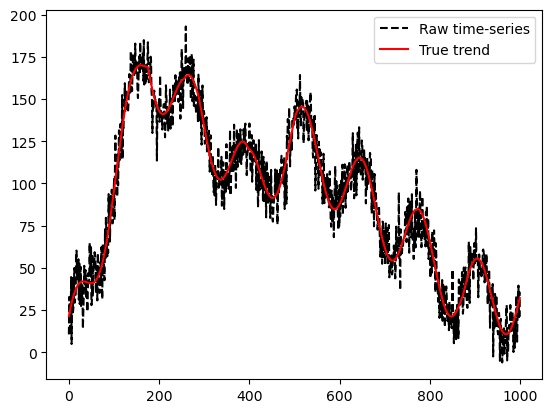

In [5]:
plt.plot(y,'k--' , label='Raw time-series')
plt.plot(x + s, 'r-', label='True trend')
plt.legend()
plt.show()

Here, we set the sparsity parameter being $18$ and estimate the period trend ``comp1`` and linear trend ``comp2`` via the function ``ptf``.

Then, the estimated trend is obtained by adding ``comp1`` and ``comp2`` and is shown in the following figure (red line).

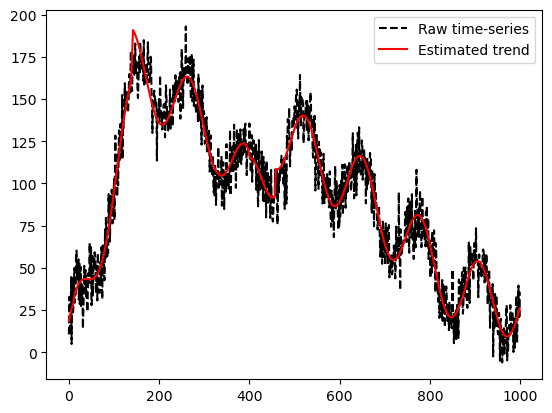

In [6]:
sparsity = 18
params = ptf(y, sparsity=sparsity)
comp1, comp2 = periods @ params[:2], A @ params[2:]

plt.plot(y, 'k--', label='Raw time-series')
plt.plot(comp1 + comp2, 'r-', label='Estimated trend')
plt.legend()
plt.show()

# Reference

- [1] Kim S J, Koh K, Boyd S, et al. $\ell_1$ trend filtering[J]. SIAM review, 2009, 51(2): 339-360.